# Tracer Transport (2D and 3D)

This notebook will solve tracer transport in a flexible way that allows for 2D and 3D domains. 

## Governing equations

#### Darcy's law

$$ - \nabla \cdot \left(K \nabla p\right) = f$$

in the domain $\Omega$, where $K$ is the permeability tensor, $p$, pressure and $f$ is a source/sink term.

Assoicated are boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$ on Dirichlet and Neumann boundaries, respectively. They are described as follows:

$$p = p_b \text{ in } \partial \Omega_d$$
and
$$ - K\nabla p \cdot \mathbf{n} = u_b \text{ in } \Omega_n$$

#### Energy equation

$$\rho C \left( \frac{\partial T}{\partial t} + \mathbf{u}\cdot \nabla T\right) = k\nabla^2 T$$

where $\rho$ is fluid density, $C$ is specific heat, and $k$ is thermal conductivity. 

## First Simplification

For this particular notebook, consider a problem where $\rho = C = 1$ and $k = 0$. Then,

$$\frac{\partial T}{\partial t} + \mathbf{u}\cdot \nabla T = 0$$

## Setup
We will solve the heat transport, but to do that, we first need to determine the parameter $\mathbf{u}$. We do this by solving Darcy's law.

### Domain

Consider a domain $[0,5]\times [0,5]$, with a fracture extending horizontally from $(1,0)$ to $(4, 0)$.

In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

In [2]:
def create_domain_2d(domain, mesh_args, fracs_coords, fracs):
    """ Create a fractured 2d domain.
    
    Parameters:
    domain (dict): Dictionary specifying domain boundaries.
        Assumes containing 'xmin', 'xmax', 'ymin', 'ymax'.
    mesh_args (dict): Dictorionary specifying meshing arguments
        Must contain keys:
            'mesh_size_frac': Mesh size in fractures. 
            'mesh_size_min': Minimum mesh size.
        Optional keys:
            'mesh_size_bound': Mesh size at boundaries.
    fracs_coords (np.ndarray 2 x n): Coordinates of fractures.
    fracs (np.ndarray 2 x num_fracs): Endpoints of fractures.
        Defines a mapping to fracs_coords.
            
    """
    network_2d = pp.FractureNetwork2d(fracs_coords, fracs, domain)
    gb = network_2d.mesh(mesh_args)
    return gb


def create_domain_3d(domain, mesh_args, fracs, mapping, more_fracs=[]):
    """ Create a fractured 3d domain.
    
    Parameters:
    domain (dict): Dictionary specifying domain boundaries.
        Assumes containing 'xmin', 'xmax', 'ymin', 'ymax', 'zmin', 'zmax'.
    mesh_args (dict): Dictorionary specifying meshing arguments
        Must contain keys:
            'mesh_size_frac': Mesh size in fractures. 
            'mesh_size_min': Minimum mesh size.
        Optional keys:
            'mesh_size_bound': Mesh size at boundaries.
    fracs (np.ndarray 3 x n): Coordinates of fractures.
    mapping (np.ndarray 4 x num_fracs): Corners of fractures.
        Defines a mapping to fracs_coords.
    more_fracs (list of pp.Fracture): More fractures to be added to
        fracture network. E.g. pp.EllipticFracture.
        
    """
    all_fracs = more_fracs
    for mp in mapping.T:
        pts = fracs[:,i]
        all_fracs.append(pp.Fracture(pts))
    
    network_3d = pp.FractureNetwork3d(all_fracs)
    gb = network_3d.mesh(mesh_args)
    return gb

#### Define a function to add some data to the domain

We will in this notebook consider Dirichlet boundaries with inflow and out flow on west and east boundaries, respectively. North and south boundaries will have Neumann, no flow.

In [3]:
def flow_dir(g, b_face_centers, flowdir, domain):
    """ Determine inflow and outflow coordinate mapping.
    
    Parameters
    g (pp.Grid): Grid
    b_face_centers (np.ndarray): Coordinates of boundary face centers
    flowdir (char): Flow direction. One of 'E', 'W', 'N', 'S', 
                                    ('U', 'D' for 3D).
    domain (dict): Domain. Assumes keys 'xmin', 'xmax', 'ymin', 'ymax',
                                    ('zmin', 'zmax' for 3D).
                                    
    """
    tol = 1e-4
    if flowdir in ['W', 'E']:
        axis = 0
        mi, ma = map(domain.get, ['xmin', 'xmax'])
    elif flowdir in ['N', 'S']:
        axis = 1
        mi, ma = map(domain.get, ['ymin', 'ymax'])
    elif flowdir in ['U', 'D']:
        axis = 2
        mi, ma = map(domain.get, ['zmin', 'zmax'])

    # flowdir in ['E', 'N', 'U']
    b_inflow = b_face_centers[axis, :] < mi + tol
    b_outflow = b_face_centers[axis, :] > ma - tol

    if flowdir in ['S', 'W', 'D']:
        b_inflow, b_outflow = b_outflow, b_inflow
    
    return b_inflow, b_outflow
            

def assign_data(gb, domain, kw_f, kw_t, **kwargs):
    """ Method to assign data for flow-transport problems.
    
    Parameters
    gb (pp.GridBucket): Grid bucket
    domain (dict): Specifies the grid boundaries.
        Assumes it contains the keys: xmin, xmax, ymin, ymax.
    kwargs (dict): Dictionary of grid data to be set. 
        Keywords are as follows:
            frac_perm (float, default: 1e3): permeability in fractures
            matrix_perm (float, default: 1): permeability in matrix
            flowdir (str, default: 'E'): Direction of flow.
                           Valid values: 'N', 'E', 'S', 'W', 'U', 'D'.
            porosity (float, default: 0.2): Porosity.

    """
    
    frac_perm = 1e3 # kwargs.get('frac_perm',1e3)
    matrix_perm = 1 # kwargs.get('matrix_perm', 1)
    flowdir = 'E' #kwargs.get('flowdir', 'E')
    poro = 1 # kwargs.get('porosity', 0.2)
    dt = 1/60 # kwargs.get('time_step', 1 / 60)
    t_max = 1/3 # kwargs.get("t_max", 1 / 3)
    
    for g, d in gb:
        
        # Assign permeability for matrix and fractures
        if g.dim == gb.dim_max():
            kxx = matrix_perm * np.ones(g.num_cells)
        else:
            kxx = frac_perm * np.ones(g.num_cells)
        perm = pp.SecondOrderTensor(kxx)
        
        # Boundary conditions
        b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
        bc_val = np.zeros(g.num_faces)
        
        unity = np.ones(g.num_cells)
        empty = np.empty(0)
        if b_faces.size != 0:
            
            b_face_centers = g.face_centers[:, b_faces]
            b_inflow, b_outflow = flow_dir(g, b_face_centers, 
                                           flowdir, domain)
            
            labels = np.array(['neu'] * b_faces.size)
            labels[np.logical_or(b_inflow, b_outflow)] = "dir"
            bc = pp.BoundaryCondition(g, b_faces, labels)
            
            # Set inflow to 4. (Outflow is 0).
            bc_val[b_faces[b_inflow]] = 4
        
        else:
            bc = pp.BoundaryCondition(g)
        
        # transport:
        #source, mass_weight, 
        #second_order_tensor, bc, bc_values, darcy_flux, time_step
        
        # flow:
        # source, mass_weight, second_order_tensor, 
        # bc, bc_values, time_step
        
        # Set parameters for flow and transport.
        specified_parameters_flow = {
            "bc": bc,
            "bc_values": bc_val,
            'second_order_tensor': perm,
            }
        
        specified_parameters_transport = {
            "bc": bc,
            "bc_values": bc_val,
            'second_order_tensor': perm,
            'time_step': dt,
            't_max': t_max
        }
        
        pp.initialize_default_data(g, d, kw_f, specified_parameters_flow)
        pp.initialize_default_data(g, d, kw_t, specified_parameters_transport)
        
        
        # Store the dimension in the dictionary for visualization purposes
        d[pp.STATE] = {"dimension": g.dim * np.ones(g.num_cells)}
    
    for e, d in gb.edges():
        #if pp.PARAMETERS not in d:
        #    d[pp.PARAMETERS] = pp.Parameters()
        
        #if keyword not in d[pp.PARAMETERS]:
        #    d[pp.PARAMETERS][keyword] = {}
        
        data = {"normal_diffusivity": 2e1}
        d[pp.PARAMETERS] = pp.Parameters(keywords=['flow_param_edge'],
                                         dictionaries=[data])
        
        d[pp.PARAMETERS].update_dictionaries([kw_f, kw_t], [{},{}])
        #d[pp.DISCRETIZATION_MATRICES][kw_f] = {}
        #d[pp.DISCRETIZATION_MATRICES][kw_t] = {}
        
        # unsure if I need these lines
        #if pp.DISCRETIZATION_MATRICES not in d:
        #    d[pp.DISCRETIZATION_MATRICES] = {}
            
        #d[pp.DISCRETIZATION_MATRICES][keyword] = {}

    return gb

In [4]:
# 2D grid
p = np.array([[1, 4], [0, 0,]])
e = np.array([[0], [1]])
domain = {'xmin': 0, 'xmax': 5, 'ymin': -2, 'ymax': 3}
mesh_args = {'mesh_size_frac': 0.2, 
             'mesh_size_bound': 0.3,
             'mesh_size_min': 0.05}
gb = create_domain_2d(domain, mesh_args, p, e)

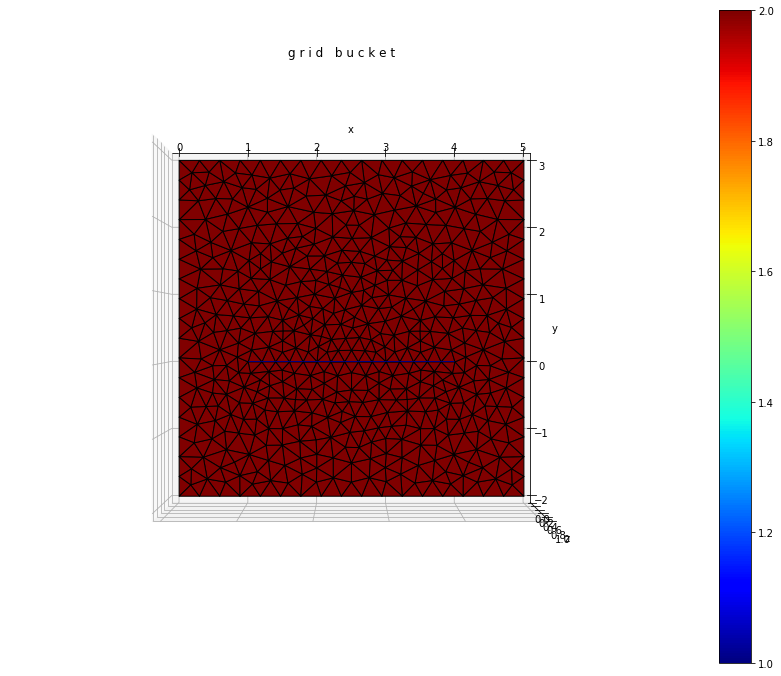

In [5]:
kw_f = "flow"
kw_t = "transport"
flow_param_edge = 'flow_param_edge'
gb = assign_data(gb, domain, kw_f=kw_f, kw_t=kw_t)
pp.plot_grid(gb, "dimension", figsize=(15,12))

In [6]:
#g2 = gb.grids_of_dimension(2)[0]
#data2 = gb.node_props(g2)
#data2[pp.PARAMETERS]

In [7]:
# Name of variables we want to solve for
grid_variable = 'pressure'
mortar_variable = 'mortar_flux'

# Name of operators we want to use
operator_keyword = 'diffusion'
coupling_operator_keyword = 'coupling_operator'

# We solve diffusion, so tpfa is the correct method:
tpfa = pp.Tpfa(kw_f)

# Set up the coupling for edges
# NOTE!!!: flow_param_edge MUST correspond to a data dict in gb.edges
# where we need: d[pp.PARAMETERS][flow_param_edge][normal_diffusivity] = ...
edge_discretization = pp.RobinCoupling(flow_param_edge, tpfa, tpfa)

# Define primary variables and discretization on each grid in the bucket
for g, d in gb:
    # primary variable is 'pressure'
    # tpfa allows for 1 degree of freedom on cells and 0 degrees on faces.
    d[pp.PRIMARY_VARIABLES] = {grid_variable: {"cells": 1, "faces": 0}}
    
    # For 'pressure', we solve 'diffusion' using tpfa.
    d[pp.DISCRETIZATION] = {grid_variable: {operator_keyword: tpfa}}

for e, d in gb.edges():
    
    # Get the grids connected by the edge (mortar).
    g1, g2 = gb.nodes_of_edge(e)
    
    # Define primary variable ('mortar_flux') on the mortar grid.
    d[pp.PRIMARY_VARIABLES] = {mortar_variable: {"cells": 1}}
    
    # Define the coupling between grids connected by the mortar.
    d[pp.COUPLING_DISCRETIZATION] = {
        coupling_operator_keyword: {
            g1: (grid_variable, operator_keyword),
            g2: (grid_variable, operator_keyword),
            e: (mortar_variable, edge_discretization),
        }
    }
    d[pp.DISCRETIZATION_MATRICES] = {flow_param_edge: {}}

/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


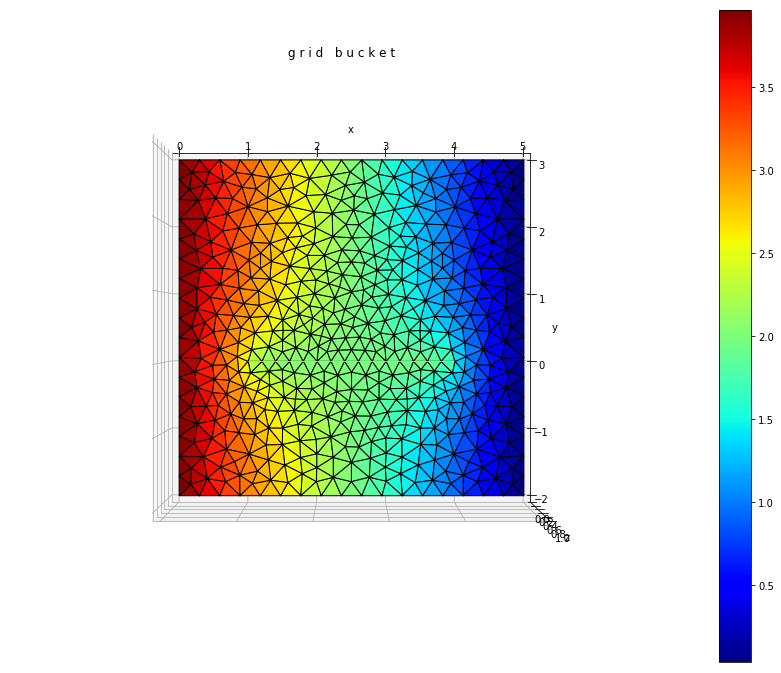

In [8]:
# Assemble and solve the linear system
assembler = pp.Assembler(gb)

# Discretize
assembler.discretize()

# Assemble the linear system
A, b = assembler.assemble_matrix_rhs()

pressure = sps.linalg.spsolve(A, b)

assembler.distribute_variable(pressure)

folder = "extended_tracer_transport"
exporter = pp.Exporter(gb, "flow", folder=folder)
exporter.write_vtk(grid_variable)
pp.plot_grid(gb, grid_variable, figsize=(15, 12))
pp.fvutils.compute_darcy_flux(gb, 
                              keyword_store=kw_t, 
                              lam_name=mortar_variable)

In [30]:
g2 = gb.grids_of_dimension(2)[0]
d2 = gb.node_props(g2)
d2[pp.PARAMETERS]['transport']['darcy_flux']

array([ 0.15472297,  0.        , -0.25812623, ...,  0.        ,
        0.        ,  0.        ])

In [32]:
class ImplicitTpfa(pp.Tpfa):
    """
    Multiply all contributions by the time step.
    """

    def assemble_matrix_rhs(self, g, data):
        """ Overwrite TPFA method to be consistent with the Biot dt convention.
        """
        a, b = super().assemble_matrix_rhs(g, data)
        dt = data[pp.PARAMETERS][self.keyword]["time_step"]
        a = a * dt
        b = b * dt
        return a, b

In [64]:
from porepy.utils.derived_discretizations import implicit_euler as IE_discretizations
# Solve transport problem

# Coupling for the temperature
grid_variable = "tracer"
mortar_variable = "mortar_tracer"

# Keyword for the temperature discretization operators
advection_term = 'advection'
mass_term = "mass"
diffusion_term = 'diffusion'
#temp_mass_operator = 'temp_mass_balance'

# Keyword for discretization operator between grids
advection_coupling_term = 'advection_coupling'

# --- DISCRETIZATION ---
# Temperature diffusion discretization
tpfa = ImplicitTpfa(kw_t)
# Advection discretization
upwind = pp.Upwind(kw_t)
# Mass discretization
mass_discretization = IE_discretizations.ImplicitMassMatrix(kw_t)

# Edge discretization
#edge_discretization_temp = pp.RobinCoupling('flow_param_edge', 
#                                             tpfa_temp, tpfa_temp)
edge_discretization = pp.UpwindCoupling(kw_t)



In [65]:
# Assign primary variable and discretization schemes on the gridbucket.
for g, d in gb:
    d[pp.PRIMARY_VARIABLES] = {
        grid_variable: {"cells":1, "faces":0}
    }

    d[pp.DISCRETIZATION] = {
        grid_variable: {advection_term: upwind,
                        diffusion_term: tpfa,
                        mass_term: mass_discretization}
    }
    if g.dim == 2:#gb.dim_max():
        data = d[pp.PARAMETERS][kw_t]

for e, d in gb.edges():
    g1, g2 = gb.nodes_of_edge(e)
    d[pp.PRIMARY_VARIABLES] = {
        mortar_variable: {'cells': 1}
    }
    d[pp.COUPLING_DISCRETIZATION] = {
        advection_coupling_term:
        {
         g1: (grid_variable, advection_term),
         g2: (grid_variable, advection_term),
         e: (grid_variable, edge_discretization),   
        }
    }    

In [66]:
for e, d in gb.edges():
    discr = d.get(pp.COUPLING_DISCRETIZATION)
    print(e)
    
    for term, val in discr.items():
        #print(term)
        #print('')
        #print(val.get(e))
        pass

(Grid with history TriangleGrid, Compute geometry
Number of cells 978
Number of faces 1516
Number of nodes 538
Dimension 2, Grid with history TensorGrid, Compute geometry
Number of cells 15
Number of faces 16
Number of nodes 16
Dimension 1)


Assemble the system


In [67]:
assembler = pp.Assembler(gb, active_variables=[grid_variable, mortar_variable])
assembler.discretize()
A,b = assembler.assemble_matrix_rhs()


KeyError: ((Grid with history TriangleGrid, Compute geometry
Number of cells 978
Number of faces 1516
Number of nodes 538
Dimension 2, Grid with history TensorGrid, Compute geometry
Number of cells 15
Number of faces 16
Number of nodes 16
Dimension 1), 'tracer')